# Classification of real data

## Install required python modules

In [ ]:
%%bash
pip install -e ../.

In [ ]:
%%bash
pip install -r ../requirements.txt

## Import data

In [2]:
import numpy as np
from openpyxl import load_workbook
import pandas as pd


filename_data = '../data/Real_data/ST001706/1D/RCCdata.txt'
filename_status = '../data/Real_data/ST001706/RCC_samples.xlsx'
df_data = pd.DataFrame(np.loadtxt(filename_data, dtype=float))
df_status = pd.read_excel(filename_status, engine='openpyxl', header=None)

#Convert status into integers
df_status[0] = df_status[0].astype('category')
df_status = df_status.apply(lambda x: x.cat.codes)

In [3]:
print(df_data.shape)
print(df_status.shape)

(256, 32697)
(256, 1)


## Shuffle the data

In [4]:
from sklearn.utils import shuffle

df_status, df_data = shuffle(df_status, df_data)

## Convert into tf.data

In [5]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((df_data, df_status[0].tolist()))
dataset.element_spec

(TensorSpec(shape=(32697,), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

## Write tf.Record

In [6]:
from tfrecords import write_tfrecords

In [7]:
write_tfrecords('../data/tfrecords/Real_data', dataset=dataset, number=10)

## Read the tf.Record files

In [6]:
from tfrecords import read_tfrecords

In [7]:
file_paths = ['../data/tfrecords/Real_data/data_{}.tfrecord'.format(i) for i in range(10)]
full_dataset = read_tfrecords(file_paths)

## Split data into train and validation datasets

In [8]:
from models import process_dataset

In [9]:
train_dataset, val_dataset, test_dataset = process_dataset(full_dataset, batch_sizes=[8] * 3, shuffle_buffers=1000,
                                                           train_prop=0.8, val_prop=0.2)

## Define Checkpoint

In [10]:
from models import CheckpointCallback

# Create a CheckpointCallback to save the model    
ckpt = CheckpointCallback("../saved_models/real_data")

## Define MLPs

In [37]:
from models import get_simple_mlp

simple_model = get_simple_mlp(input_shape=(32697,), hidden_units=[32])
simple_model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32697)]           0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1046336   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 1,046,369
Trainable params: 1,046,369
Non-trainable params: 0
_________________________________________________________________


In [38]:
from models import get_regularised_bn_dropout_mlp

regularised_bn_dropout_model = get_regularised_bn_dropout_mlp(input_shape=(32697,), hidden_units=[32],
                                l2_reg_coeff=0.00001, dropout_rate=0.8)
regularised_bn_dropout_model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32697)]           0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1046336   
_________________________________________________________________
batch_normalization_7 (Batch (None, 32)                128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 1,046,497
Trainable params: 1,046,433
Non-trainable params: 64
_________________________________________________________________


## Compile simple model

In [39]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
earlystopping = tf.keras.callbacks.EarlyStopping(patience=100)

In [40]:
simple_model.compile(optimizer=opt, loss=loss, metrics=[acc])
simple_history = simple_model.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[ckpt, earlystopping])

Epoch 1/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.6084 - binary_accuracy: 0.6850 - val_loss: 0.2863 - val_binary_accuracy: 0.8800
Epoch 2/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.4346 - binary_accuracy: 0.7800 - val_loss: 0.4597 - val_binary_accuracy: 0.8000
Epoch 3/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.3167 - binary_accuracy: 0.8400 - val_loss: 0.2279 - val_binary_accuracy: 0.8600
Epoch 4/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.2786 - binary_accuracy: 0.8650 - val_loss: 0.2715 - val_binary_accuracy: 0.8800
Epoch 5/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1896 - binary_accuracy: 0.9500 - val_loss: 0.2407 - val_binary_accuracy: 0.8800
Epoch 6/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1639 - binary_accuracy: 0.9550 - val_loss: 0.1770 - val_binary_accuracy: 0.9200
Epoch 7/1000
25/25 [==============================] - 0s 8ms/st

25/25 [==============================] - 0s 8ms/step - loss: 0.0055 - binary_accuracy: 1.0000 - val_loss: 0.2847 - val_binary_accuracy: 0.9000
Epoch 54/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0052 - binary_accuracy: 1.0000 - val_loss: 0.3416 - val_binary_accuracy: 0.9000
Epoch 55/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0050 - binary_accuracy: 1.0000 - val_loss: 0.3031 - val_binary_accuracy: 0.9200
Epoch 56/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0048 - binary_accuracy: 1.0000 - val_loss: 0.3620 - val_binary_accuracy: 0.9000
Epoch 57/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0048 - binary_accuracy: 1.0000 - val_loss: 0.3280 - val_binary_accuracy: 0.9200
Epoch 58/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0045 - binary_accuracy: 1.0000 - val_loss: 0.3163 - val_binary_accuracy: 0.9000
Epoch 59/1000
25/25 [==============================] - 0s 8ms/step - los

25/25 [==============================] - 0s 8ms/step - loss: 0.0010 - binary_accuracy: 1.0000 - val_loss: 0.4106 - val_binary_accuracy: 0.9200
Epoch 106/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0011 - binary_accuracy: 1.0000 - val_loss: 0.4620 - val_binary_accuracy: 0.8800
Epoch 107/1000
25/25 [==============================] - 0s 9ms/step - loss: 9.5516e-04 - binary_accuracy: 1.0000 - val_loss: 0.4504 - val_binary_accuracy: 0.9000
Epoch 108/1000
25/25 [==============================] - 0s 8ms/step - loss: 9.5676e-04 - binary_accuracy: 1.0000 - val_loss: 0.4715 - val_binary_accuracy: 0.8800
Epoch 109/1000
25/25 [==============================] - 0s 8ms/step - loss: 9.0204e-04 - binary_accuracy: 1.0000 - val_loss: 0.4591 - val_binary_accuracy: 0.9000
Epoch 110/1000
25/25 [==============================] - 0s 8ms/step - loss: 8.8807e-04 - binary_accuracy: 1.0000 - val_loss: 0.4619 - val_binary_accuracy: 0.9000
Epoch 111/1000
25/25 [=============================

## Plot the learning curves

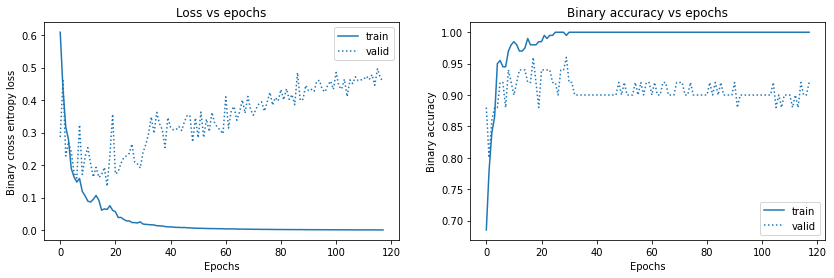

{'loss': 0.45690274238586426, 'binary_accuracy': 0.9200000166893005}


In [41]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(simple_history.history['loss'], label='train', color='C0', linestyle='-')
plt.plot(simple_history.history['val_loss'], label='valid', color='C0', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
plt.legend()

fig.add_subplot(122)
plt.plot(simple_history.history['binary_accuracy'], label='train', color='C0', linestyle='-')
plt.plot(simple_history.history['val_binary_accuracy'], label='valid', color='C0', linestyle=':')
plt.title("Binary accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary accuracy")
plt.legend()

plt.show()
print(simple_model.evaluate(val_dataset, return_dict=True, verbose=0))

## Compile regularized model

In [42]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
earlystopping = tf.keras.callbacks.EarlyStopping(patience=100)

In [43]:
regularised_bn_dropout_model.compile(optimizer=opt, loss=loss, metrics=[acc])
regularised_history = regularised_bn_dropout_model.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[ckpt, earlystopping])

Epoch 1/1000
25/25 [==============================] - 0s 12ms/step - loss: 1.2178 - binary_accuracy: 0.6100 - val_loss: 0.3497 - val_binary_accuracy: 0.8000
Epoch 2/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.7738 - binary_accuracy: 0.7200 - val_loss: 0.2758 - val_binary_accuracy: 0.9000
Epoch 3/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.9129 - binary_accuracy: 0.6750 - val_loss: 0.3554 - val_binary_accuracy: 0.8600
Epoch 4/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.7549 - binary_accuracy: 0.7350 - val_loss: 0.5686 - val_binary_accuracy: 0.7000
Epoch 5/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.6540 - binary_accuracy: 0.7500 - val_loss: 0.2784 - val_binary_accuracy: 0.8600
Epoch 6/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.5341 - binary_accuracy: 0.7700 - val_loss: 0.1756 - val_binary_accuracy: 0.9400
Epoch 7/1000
25/25 [==============================] - 0s 8ms/s

25/25 [==============================] - 0s 9ms/step - loss: 0.2268 - binary_accuracy: 0.8950 - val_loss: 0.3096 - val_binary_accuracy: 0.8800
Epoch 54/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.2128 - binary_accuracy: 0.9100 - val_loss: 0.3004 - val_binary_accuracy: 0.8800
Epoch 55/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.2408 - binary_accuracy: 0.8800 - val_loss: 0.1814 - val_binary_accuracy: 0.9400
Epoch 56/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.2199 - binary_accuracy: 0.9250 - val_loss: 0.1865 - val_binary_accuracy: 0.9400
Epoch 57/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.2237 - binary_accuracy: 0.9050 - val_loss: 0.2416 - val_binary_accuracy: 0.9200
Epoch 58/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.2841 - binary_accuracy: 0.8750 - val_loss: 0.3878 - val_binary_accuracy: 0.8400
Epoch 59/1000
25/25 [==============================] - 0s 9ms/step - lo

25/25 [==============================] - 0s 9ms/step - loss: 0.1937 - binary_accuracy: 0.9400 - val_loss: 0.1575 - val_binary_accuracy: 0.9200
Epoch 106/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.2037 - binary_accuracy: 0.9250 - val_loss: 0.1570 - val_binary_accuracy: 0.9400
Epoch 107/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1588 - binary_accuracy: 0.9350 - val_loss: 0.1579 - val_binary_accuracy: 0.9400
Epoch 108/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.2208 - binary_accuracy: 0.9100 - val_loss: 0.2441 - val_binary_accuracy: 0.9000
Epoch 109/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1933 - binary_accuracy: 0.9350 - val_loss: 0.1605 - val_binary_accuracy: 0.9400
Epoch 110/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1773 - binary_accuracy: 0.9300 - val_loss: 0.1744 - val_binary_accuracy: 0.9200
Epoch 111/1000
25/25 [==============================] - 0s 9ms/step

Epoch 157/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1804 - binary_accuracy: 0.9350 - val_loss: 0.4474 - val_binary_accuracy: 0.8400
Epoch 158/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1344 - binary_accuracy: 0.9450 - val_loss: 0.1839 - val_binary_accuracy: 0.9400
Epoch 159/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1202 - binary_accuracy: 0.9650 - val_loss: 0.1717 - val_binary_accuracy: 0.9000
Epoch 160/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.1792 - binary_accuracy: 0.9450 - val_loss: 0.3297 - val_binary_accuracy: 0.8600
Epoch 161/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1849 - binary_accuracy: 0.9300 - val_loss: 0.2505 - val_binary_accuracy: 0.9000
Epoch 162/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0964 - binary_accuracy: 0.9550 - val_loss: 0.1811 - val_binary_accuracy: 0.9200
Epoch 163/1000
25/25 [=============================

## Plot the learning curves

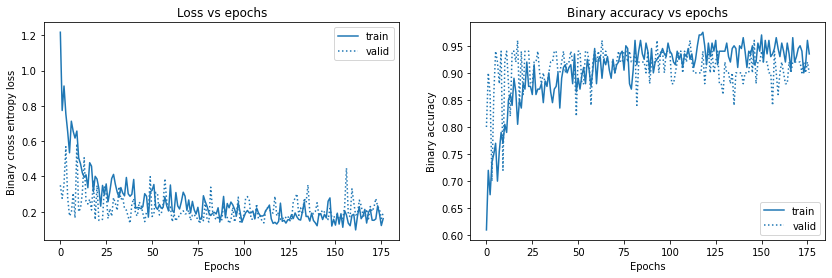

{'loss': 0.1925497204065323, 'binary_accuracy': 0.8999999761581421}


In [44]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(regularised_history.history['loss'], label='train', color='C0', linestyle='-')
plt.plot(regularised_history.history['val_loss'], label='valid', color='C0', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
plt.legend()

fig.add_subplot(122)
plt.plot(regularised_history.history['binary_accuracy'], label='train', color='C0', linestyle='-')
plt.plot(regularised_history.history['val_binary_accuracy'], label='valid', color='C0', linestyle=':')
plt.title("Binary accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary accuracy")
plt.legend()

plt.show()
print(regularised_bn_dropout_model.evaluate(val_dataset, return_dict=True, verbose=0))

## Load saved model

In [107]:
from models import get_simple_mlp
import tensorflow as tf


simple_model_load = get_simple_mlp(input_shape=(32697,), hidden_units=[64, 64])
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
simple_model_load.compile(optimizer=opt, loss=loss, metrics=[acc])
status = tf.train.Checkpoint(model=simple_model_load).restore(tf.train.latest_checkpoint('../saved_models/real_data')).expect_partial()
status.assert_existing_objects_matched()
simple_model_load.evaluate(val_dataset, return_dict=True, verbose=0)


Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32697)]           0         
_________________________________________________________________
dense_74 (Dense)             (None, 64)                2092672   
_________________________________________________________________
dense_75 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 65        
Total params: 2,096,897
Trainable params: 2,096,897
Non-trainable params: 0
_________________________________________________________________


{'loss': 0.17636698484420776, 'binary_accuracy': 0.9399999976158142}

## Plot examples with predictions

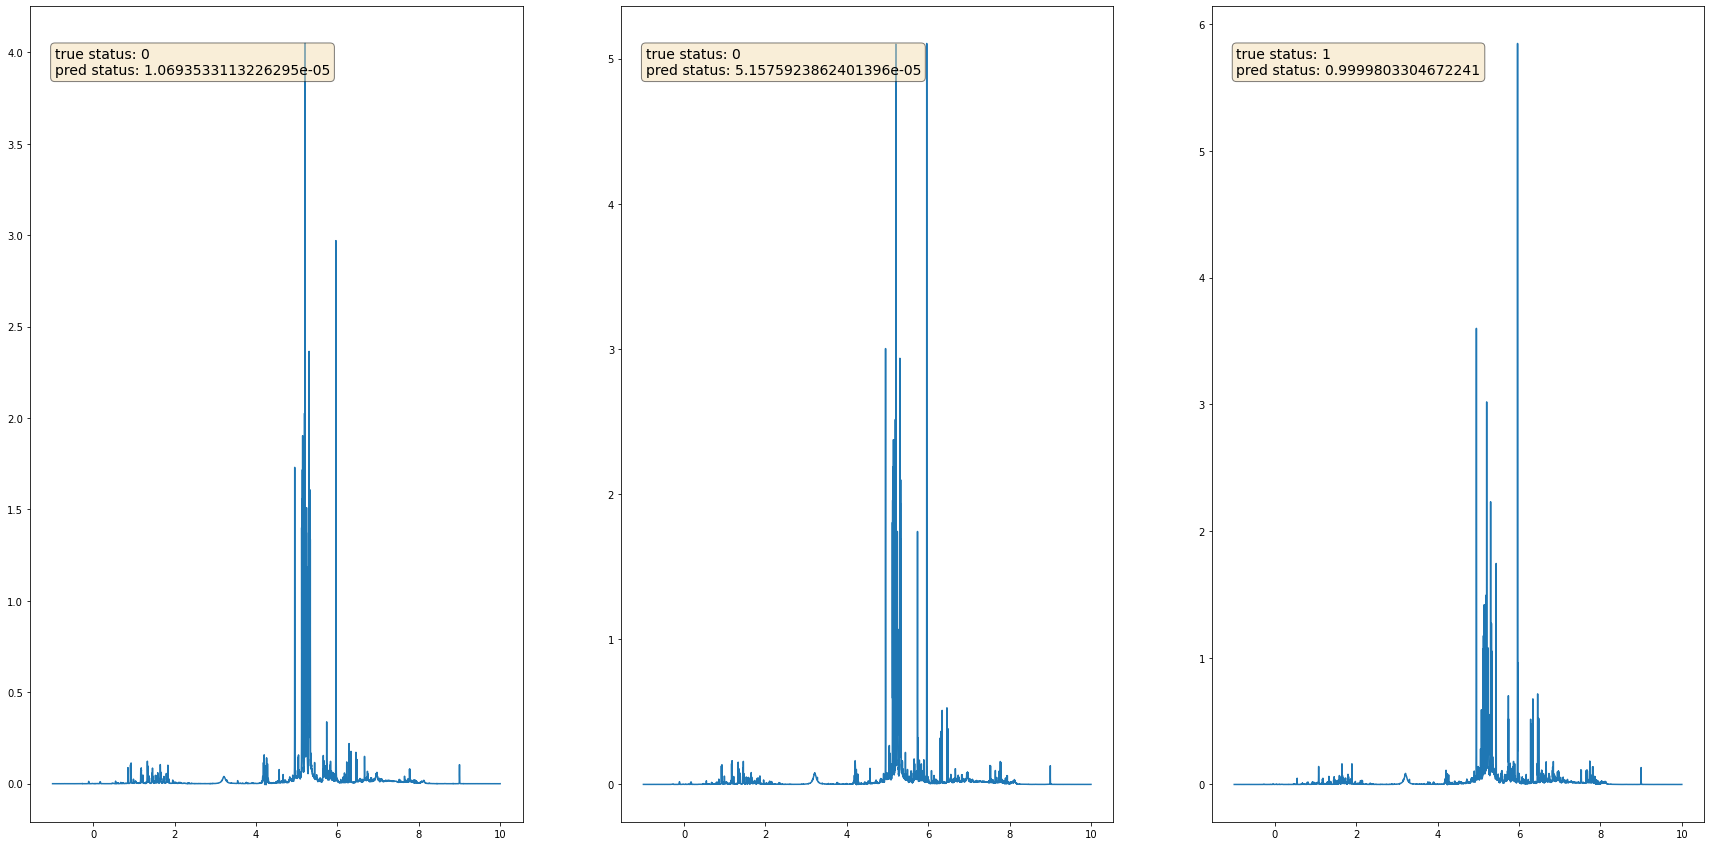

In [46]:
#Plot samples
import matplotlib.pyplot as plt
import numpy as np

for parsed_record in val_dataset.shuffle(10).take(1):
    data_points_0 = parsed_record[0][0]
    data_points_1 = parsed_record[0][1]
    data_points_2 = parsed_record[0][2]
    true_status_0 = parsed_record[1][0].numpy()
    true_status_1 = parsed_record[1][1].numpy()
    true_status_2 = parsed_record[1][2].numpy()
    pred_status_0 = simple_model.predict(parsed_record[0])[0][0]
    pred_status_1 = simple_model.predict(parsed_record[0])[1][0]
    pred_status_2 = simple_model.predict(parsed_record[0])[2][0]


import matplotlib.pyplot as plt

label_0 = '\n'.join((
    r'true status: {}'.format(true_status_0),
    r'pred status: {}'.format(pred_status_0)))

label_1 = '\n'.join((
    r'true status: {}'.format(true_status_1),
    r'pred status: {}'.format(pred_status_1)))

label_2 = '\n'.join((
    r'true status: {}'.format(true_status_2),
    r'pred status: {}'.format(pred_status_2)))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)



n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 15))
x_axis_0 = np.linspace(-1, 10, num=data_points_0.shape[0])
x_axis_1 = np.linspace(-1, 10, num=data_points_1.shape[0])
x_axis_2 = np.linspace(-1, 10, num=data_points_2.shape[0])
axes[0].plot(x_axis_0, data_points_0, label=[('true status: ', true_status_0), ('pred status: ', pred_status_0)])
axes[1].plot(x_axis_1, data_points_1)
axes[2].plot(x_axis_2, data_points_2)

# place a text box in upper left in axes coords
axes[0].text(0.05, 0.95, label_0, transform=axes[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axes[1].text(0.05, 0.95, label_1, transform=axes[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axes[2].text(0.05, 0.95, label_2, transform=axes[2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

## Try random forest

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_data, df_status[0], test_size=0.2, random_state=42)

clf = RandomForestClassifier(1000, random_state=0, oob_score=True, max_features=700)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=700, n_estimators=1000, oob_score=True,
                       random_state=0)

In [97]:
print("Train accuracy :", clf.score(X_train, y_train))
print("Test accuracy :", clf.score(X_test, y_test))

Train accuracy : 1.0
Test accuracy : 0.9230769230769231
